### Impotar librerias y definir variables globales

In [95]:
#Importar Librerias
import pandas as pd 
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime 
from IPython.display import Image
NOW = "09/03/2020"

### Definir la ruta base y leer los datos

In [96]:
mainpath = "D:/Empresas/DSR/Analitica_Micromobilidad/"
dataname = "test.csv"
dataoutput = "RFM_Segmento_1002_to_2802"

fullpathdata = os.path.join(mainpath,dataname)
fullpathoutput = os.path.join(mainpath,dataoutput)

In [97]:
print(fullpathdata)
print(fullpathoutput)
print(NOW)

D:/Empresas/DSR/Analitica_Micromobilidad/test.csv
D:/Empresas/DSR/Analitica_Micromobilidad/RFM_Segmento_1002_to_2802
09/03/2020


# Funciones de Apoyo

### Defenir Funciones de resta y formato de fechas 

In [98]:
def days_between(d1, d2):
  #  d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%d/%m/%Y")
    return abs((d2 - d1).days)

In [99]:
def format_date(d):
    return d[0:2] + "/"+ d[3:5] + "/2020"

### Definir las fuciones de Scores en base a los quintiles

In [100]:
def r_score(x,quintiles):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1
def fm_score(x, c,quintiles):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5

### Definir función para hallar el Score en base a los quintiles

In [101]:
def rfm_table_score(rfm_table,quintiles): 
    rfm_table['R'] = rfm_table['Recency'].apply(lambda x: r_score(x,quintiles))
    rfm_table['F'] = rfm_table['Frequency'].apply(lambda x: fm_score(x, 'Frequency',quintiles))
    rfm_table['M'] = rfm_table['Monetary'].apply(lambda x: fm_score(x, 'Monetary',quintiles))
    rfm_table['RFM Score'] = rfm_table['R'].map(str) + rfm_table['F'].map(str) + rfm_table['M'].map(str)
    return rfm_table

### Definir función para hallar los segmentos

In [102]:
def rfm_table_segment(rfm_table,segt_map,segt_other):
    rfm_table['Segment'] = rfm_table['RFM Score']
    rfm_table['Segment'] = rfm_table['Segment'].replace(segt_map, regex=True)
    rfm_table['Segment'] = rfm_table['Segment'].replace(segt_other, regex=True)
    return rfm_table

### Los Segmentos del RFM y las REGLAS son los siguientes : 

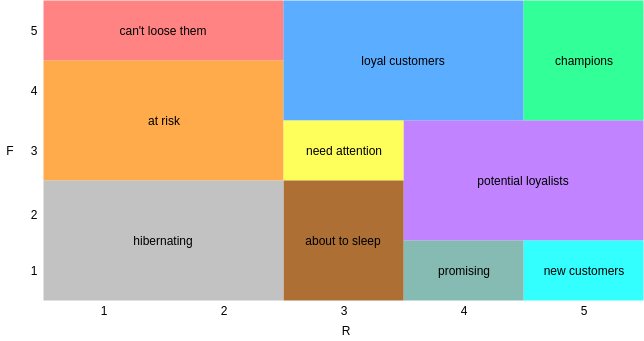

In [103]:
Image(filename=mainpath+'rfm-segments.png')

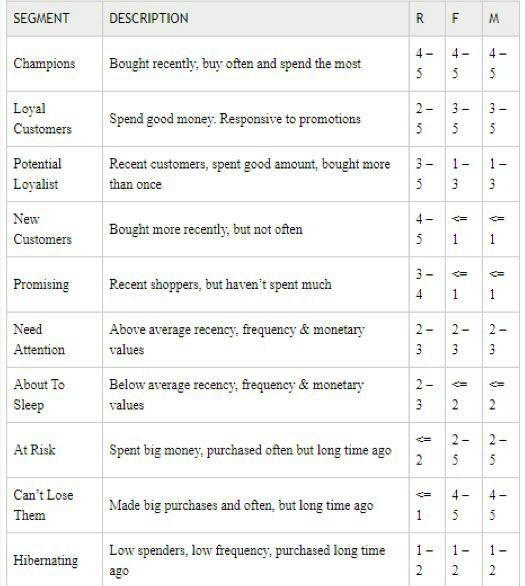

In [104]:
Image(filename=mainpath+'RFM_Rules.jpg',width=400,height=60)

In [105]:
segt_map = {
    r'[4-5][4-5][4-5]': 'A. Champions',
    r'[2-5][3-5][3-5]': 'B. Loyal Customers',
    r'[3-5][1-3][1-3]': 'C. Potential Loyalist',
    r'[4-5]11': 'D. New Customers',
    r'[3-4]11': 'E. Promising',
    r'[2-3][2-3][2-3]': 'F. Need Attention',
    r'[2-3][1-2][1-2]': 'G. About to Sleep',
    r'[1-2][2-5][2-5]': 'H. At Risk',
    r'1[4-5][4-5]': 'I. Can\'t Lose Them',
    r'[1-2][1-2][1-2]': 'J. Hibernating',
    r'55[1-2]': 'K. Outlier',
    r'11[4-5]': 'K. Outlier'
}

segt_other={r'[0-9]+':'L. Others'}

# Lógica de Clustering

### Estructurar la data , leemos la data que descargamos del libro summary (todas las transacciones)

In [129]:
data_all = pd.read_csv(fullpathdata,sep=",")
data_all.head(10)

,#Trips Out Of GeoFence,%Utilization over Scooters Deployed,Cabify Avg. Duration (mins),Blank 2,Blank 3,Blank 4,Cabify Fee,Cabify Avg. Ticket,%Utilization over Total Fleet,New Users w/Discount,...,trip_region,trips_order,type,updated_at,usd_xr,user_registration_date,vehicleid,zone_end,zone_final,zone_start
0,0,66%,4.3,NaN,NaN,NaN,0,1.0,314200%,0,...,Lima,5.0,kick,02/26/2020 8:44,0.294955,08/26/2019 10:52,movo-scooter:18000,PER-LIM-E1,PER-LIM-E1,PER-LIM-E1
1,0,55%,NaN,NaN,NaN,NaN,0,NaN,258400%,0,...,Lima,11.0,kick,08/03/2020 20:36,0.294955,09/25/2019 21:15,movo-scooter:18889,PER-LIM-E1,PER-LIM-G,PER-LIM-G
2,0,55%,NaN,NaN,NaN,NaN,0,NaN,257300%,0,...,Lima,10.0,kick,02/23/2020 17:11,0.294955,09/25/2019 21:15,movo-scooter:17978,PER-LIM-G,PER-LIM-G,PER-LIM-G
3,0,55%,NaN,NaN,NaN,NaN,0,NaN,257300%,1,...,Lima,1.0,kick,02/23/2020 21:04,0.294955,02/23/2020 20:33,movo-scooter:14813,PER-LIM-E1,PER-LIM-E1,PER-LIM-E1
4,0,69%,NaN,NaN,NaN,NaN,0,NaN,334800%,0,...,Lima,1.0,kick,02/27/2020 13:05,0.294955,02/27/2020 10:16,movo-scooter:8673,PER-LIM-D,PER-LIM-B,PER-LIM-B
5,0,68%,NaN,NaN,NaN,NaN,0,NaN,323100%,0,...,Lima,22.0,kick,04/03/2020 21:07,0.294955,09/21/2019 17:17,movo-scooter:8826,PER-LIM-E,PER-LIM-E1,PER-LIM-E1
6,0,68%,NaN,NaN,NaN,NaN,0,NaN,323100%,0,...,Lima,21.0,kick,04/03/2020 19:44,0.294955,09/21/2019 17:17,movo-scooter:8826,PER-LIM-E1,PER-LIM-E1,PER-LIM-E1
7,0,68%,NaN,NaN,NaN,NaN,0,NaN,344100%,0,...,Lima,34.0,kick,02/21/2020 12:37,0.294955,03/04/2019 20:28,movo-scooter:9682,PER-LIM-B,PER-LIM-B,PER-LIM-B
8,0,58%,NaN,NaN,NaN,NaN,0,NaN,286300%,0,...,Lima,1.0,kick,07/03/2020 20:54,0.294955,02/21/2020 20:05,movo-scooter:9091,PER-LIM-E,PER-LIM-D,PER-LIM-D
9,0,58%,NaN,NaN,NaN,NaN,0,NaN,286300%,0,...,Lima,2.0,kick,07/03/2020 22:30,0.294955,02/21/2020 20:05,movo-scooter:16020,PER-LIM-E,PER-LIM-E,PER-LIM-E


In [130]:
data_all.columns

Index(['#Trips Out Of GeoFence', '%Utilization over Scooters Deployed',
       'Cabify Avg. Duration (mins)', 'Blank 2', 'Blank 3', 'Blank 4',
       'Cabify Fee', 'Cabify Avg. Ticket', '%Utilization over Total Fleet',
       'New Users w/Discount',
       ...
       'trip_region', 'trips_order', 'type', 'updated_at', 'usd_xr',
       'user_registration_date', 'vehicleid', 'zone_end', 'zone_final',
       'zone_start'],
      dtype='object', length=154)

### Filtramos las columnas necesarias para el cluster
#### UserId -> Identificador único del usuario 
#### region_final -> Ciudad 
#### #Trips -> Variable de trip 
#### GMV - Rectifications -> GMV en dolares 
#### Time -> Fecha de la transacción
#### Active Users -> Identificador si el usuario es activo con nuestro producto
#### Type -> Tipo de Asset

In [131]:
columns_table = ["UserId", "region_final", "#Trips","GMV - Rectifications","Time","Active Users","type"]
row_filter = data_all["Active Users"]==1
data_reduce = data_all[row_filter][columns_table]
data_reduce.head(10)

,UserId,region_final,#Trips,GMV - Rectifications,Time,Active Users,type
0,2Hire:493113,Lima,1,1.032342,02/26/2020,1,kick
1,2Hire:615547,Lima,1,1.032342,03/08/2020,1,kick
2,2Hire:615547,Lima,1,0.736089,02/23/2020,1,kick
3,2Hire:960601,Lima,1,4.128069,02/23/2020,1,kick
4,2Hire:965978,Lima,1,9.291076,02/27/2020,1,kick
5,2Hire:598047,Lima,1,2.800419,03/04/2020,1,kick
6,2Hire:598047,Lima,1,1.621897,03/04/2020,1,kick
7,2Hire:91227,Lima,1,0.589910,02/21/2020,1,kick
8,2Hire:956039,Lima,1,2.507116,03/07/2020,1,kick
9,2Hire:956039,Lima,1,1.917206,03/07/2020,1,kick


In [132]:
data_reduce["Fecha"] = data_reduce["Time"].apply(lambda x: format_date(x))
data_reduce.head(5)

,UserId,region_final,#Trips,GMV - Rectifications,Time,Active Users,type,Fecha
0,2Hire:493113,Lima,1,1.032342,02/26/2020,1,kick,02/26/2020
1,2Hire:615547,Lima,1,1.032342,03/08/2020,1,kick,03/08/2020
2,2Hire:615547,Lima,1,0.736089,02/23/2020,1,kick,02/23/2020
3,2Hire:960601,Lima,1,4.128069,02/23/2020,1,kick,02/23/2020
4,2Hire:965978,Lima,1,9.291076,02/27/2020,1,kick,02/27/2020


In [133]:
data_reduce["Fecha_"] = data_reduce["Fecha"].apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))
data_reduce.head(5)

,UserId,region_final,#Trips,GMV - Rectifications,Time,Active Users,type,Fecha,Fecha_
0,2Hire:493113,Lima,1,1.032342,02/26/2020,1,kick,02/26/2020,2020-02-26
1,2Hire:615547,Lima,1,1.032342,03/08/2020,1,kick,03/08/2020,2020-03-08
2,2Hire:615547,Lima,1,0.736089,02/23/2020,1,kick,02/23/2020,2020-02-23
3,2Hire:960601,Lima,1,4.128069,02/23/2020,1,kick,02/23/2020,2020-02-23
4,2Hire:965978,Lima,1,9.291076,02/27/2020,1,kick,02/27/2020,2020-02-27


### Definirmos el RFM Table : Frequency,Monetary y Recency

In [134]:
rfm_table_global = data_reduce.groupby(['UserId','region_final',"type"]).agg({
        'Fecha_': lambda x: x.max(),
        '#Trips': 'count',
        'GMV - Rectifications': 'sum'}).reset_index()
rfm_table_global.rename(columns={ 'region_final':'Region',
                         'Fecha_':"Fecha",
                         '#Trips': 'Frequency',
                         'GMV - Rectifications': 'Monetary'}, inplace=True)
rfm_table_global["Recency"] = rfm_table_global["Fecha"].apply(lambda x: days_between(x,NOW))
rfm_table_global.head(10)

,UserId,Region,type,Fecha,Frequency,Monetary,Recency
0,2Hire:100166,Lima,kick,2020-03-07,10,9.291076,2
1,2Hire:100243,Lima,kick,2020-03-02,8,7.227749,7
2,2Hire:100572,Lima,kick,2020-03-03,1,1.179819,6
3,2Hire:100690,Lima,kick,2020-02-23,1,3.095728,15
4,2Hire:100934,Lima,kick,2020-03-06,10,40.108130,3
5,2Hire:100943,Lima,kick,2020-03-03,2,2.064684,6
6,2Hire:101267,Lima,kick,2020-02-26,3,3.689295,12
7,2Hire:101453,Lima,kick,2020-02-21,2,3.686935,17
8,2Hire:101458,Lima,kick,2020-02-20,1,1.179819,18
9,2Hire:101498,Lima,kick,2020-03-05,1,0.884864,4


In [135]:
columns_table = ["Region", "type"]
data_type = rfm_table_global[columns_table]
data_type_asset = data_type.drop_duplicates(['Region','type']).reset_index()
data_type_asset.head(15)

,index,Region,type
0,0,Lima,kick


### Descripción general de los datos  e Histogramas 

In [136]:
rfm_table_global.describe()

,Frequency,Monetary,Recency
count,17396.000000,17396.000000,17396.000000
mean,3.044895,6.158587,8.044263
std,4.011395,8.049756,5.184450
min,1.000000,-0.003480,1.000000
25%,1.000000,1.622251,3.000000
50%,2.000000,3.098382,7.000000
75%,3.000000,7.078915,12.000000
max,76.000000,147.320837,18.000000


Text(0.5, 1.0, 'Histograma de Frequency de Lima - kick')

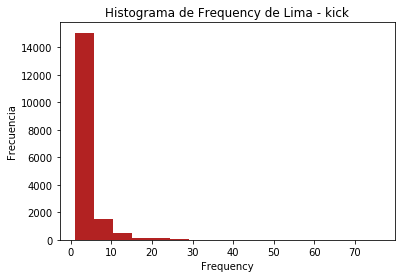

In [137]:
k = int(np.ceil(1+np.log2(18000)))
plt.hist(rfm_table_global["Frequency"],bins= k, color="firebrick")
plt.xlabel("Frequency")
plt.ylabel("Frecuencia")
plt.title("Histograma de Frequency de " + city +" - " + asset )

Text(0.5, 1.0, 'Histograma de Monetary Lima - kick')

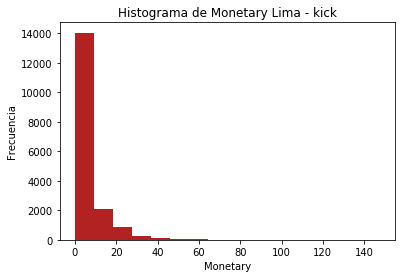

In [138]:
plt.hist(rfm_table_global["Monetary"],bins= k, color="firebrick")
plt.xlabel("Monetary")
plt.ylabel("Frecuencia")
plt.title("Histograma de Monetary " + city +" - " + asset )

Text(0.5, 1.0, 'Histograma de RecencyLima - kick')

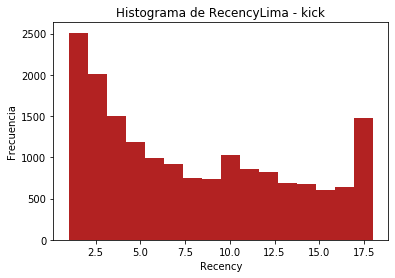

In [139]:
plt.hist(rfm_table_global["Recency"],bins= k, color="firebrick")
plt.xlabel("Recency")
plt.ylabel("Frecuencia")
plt.title("Histograma de Recency" + city +" - " + asset )

### Definimos los quintiles de las variles Frequency,Monetary y Recency 

In [140]:
quintiles_analysis = rfm_table_global[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles_analysis_df = pd.DataFrame(quintiles_analysis)
quintiles_analysis_df.head(15)

,Recency,Frequency,Monetary
0.2,3.0,1.0,1.473476
0.4,5.0,1.0,2.503222
0.6,9.0,2.0,4.273954
0.8,13.0,4.0,8.848644


### Hallamos el RFM & Score GLOBAL

In [141]:
rfm_table_global = rfm_table_score(rfm_table_global,quintiles_analysis)
rfm_table_global.head(5)

,UserId,Region,type,Fecha,Frequency,Monetary,Recency,R,F,M,RFM Score
0,2Hire:100166,Lima,kick,2020-03-07,10,9.291076,2,5,5,5,555
1,2Hire:100243,Lima,kick,2020-03-02,8,7.227749,7,3,5,4,354
2,2Hire:100572,Lima,kick,2020-03-03,1,1.179819,6,3,1,1,311
3,2Hire:100690,Lima,kick,2020-02-23,1,3.095728,15,1,1,3,113
4,2Hire:100934,Lima,kick,2020-03-06,10,40.108130,3,5,5,5,555


### Asignamos el Segmento segun las reglas 

In [142]:
rfm_table_global = rfm_table_segment(rfm_table_global,segt_map,segt_other)
rfm_table_global.head(5)

,UserId,Region,type,Fecha,Frequency,Monetary,Recency,R,F,M,RFM Score,Segment
0,2Hire:100166,Lima,kick,2020-03-07,10,9.291076,2,5,5,5,555,A. Champions
1,2Hire:100243,Lima,kick,2020-03-02,8,7.227749,7,3,5,4,354,B. Loyal Customers
2,2Hire:100572,Lima,kick,2020-03-03,1,1.179819,6,3,1,1,311,C. Potential Loyalist
3,2Hire:100690,Lima,kick,2020-02-23,1,3.095728,15,1,1,3,113,L. Others
4,2Hire:100934,Lima,kick,2020-03-06,10,40.108130,3,5,5,5,555,A. Champions


### Escribimos el archivo con los resultados

In [143]:
rfm_table_global.to_csv(fullpathoutput+".csv")

### Distribución por Segmentos

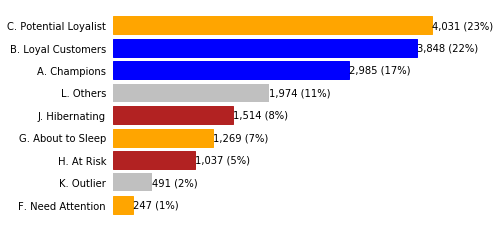

In [144]:
segments_counts = rfm_table_global['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['A. Champions', 'B. Loyal Customers']:
            bar.set_color('blue')
        if segments_counts.index[i] in ['C. Potential Loyalist', 'F. Need Attention',"G. About to Sleep"]:
            bar.set_color('orange')
        if segments_counts.index[i] in ['J. Hibernating', 'H. At Risk']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

### Distribución de Frequency,Monetary y Recency

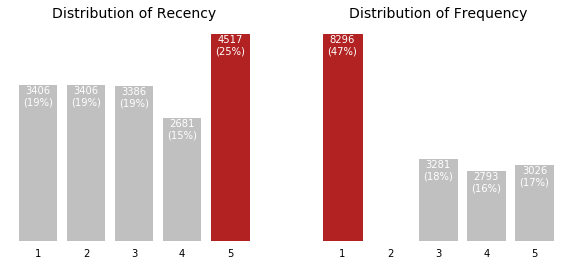

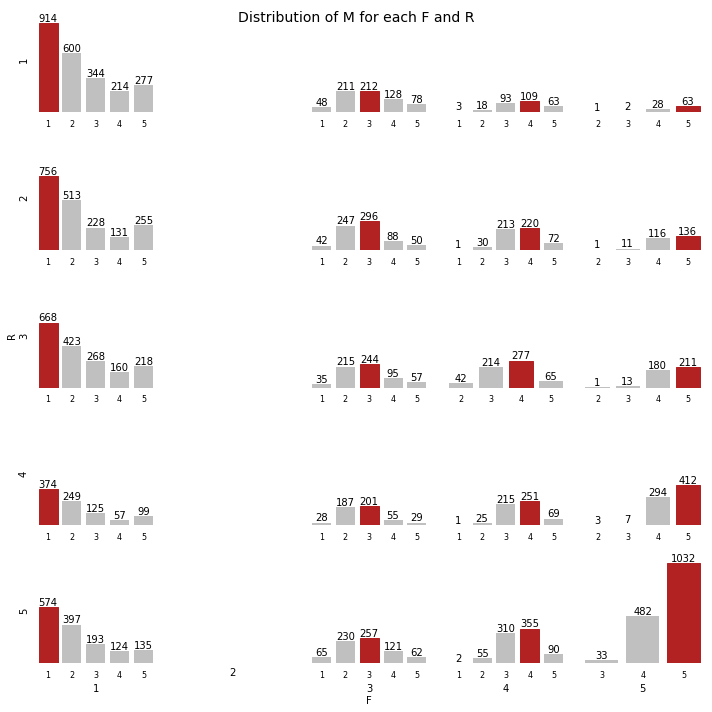

In [147]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = rfm_table_global[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')
        
plt.show()

# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = rfm_table_global[(rfm_table_global['R'] == r) & (rfm_table_global['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()